# Finding adversarial examples, in depth

Using the same example from the quickstart, we explore how to get more out of the function `find_adversarial_example`

In [1]:
using MIPVerify
using HiGHS
using JuMP
using Images
using Printf

mnist = MIPVerify.read_datasets("MNIST")
n1 = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.test.images, 1);

function print_summary(d::Dict)
    # Helper function to print out output
    obj_val = JuMP.objective_value(d[:Model])
    solve_time = JuMP.solve_time(d[:Model])
    println("Objective Value: $(@sprintf("%.6f", obj_val)), Solve Time: $(@sprintf("%.2f", solve_time))")
end

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff .+ 1) ./ 2 .* n)]
end

view_diff (generic function with 1 method)

## `find_adversarial_example`

`find_adversarial_example` takes five positional arguments

```
find_adversarial_example(nn, input, target_selection, optimizer, main_solve_options)
```

It also takes named arguments, each with the default value specified.

```
invert_target_selection = false
pp = MIPVerify.UnrestrictedPerturbationFamily()
norm_order = 1
adversarial_example_objective = closest
tightening_algorithm = mip
tightening_options: same as main solver, but with output suppressed and a time limit of 20s per solve.
solve_if_predicted_in_targeted = true
```

See [full documentation here](https://vtjeng.com/MIPVerify.jl/dev/finding_adversarial_examples/single_image/#MIPVerify.find_adversarial_example-Tuple{NeuralNet,%20Array{%3C:Real},%20Union{Integer,%20Vector{%3C:Integer}},%20Any,%20Dict}).

We explore what some of these options allow us to do.

# Basic Options

## Specifying target categories for the adversarial example

`target_selection` and `invert_target_selection` control what the category we want the adversarial example to be classified in.

`target_selection` accepts either a single integer or a list of integers.

For example, if I wanted the original image (which is the digit 7) to be classified as the digit 8 or 9, I could run two separate solves with `target_selection=9` and `target_selection=10` (Julia is 1-indexed), finding closest adversarial examples at an $L_\infty$ distance `0.104073` and `0.046085` ...

In [2]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    9, 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.105),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.104073, Solve Time: 105.14


In [3]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.105),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.046085, Solve Time: 281.74


Or I can can pass the targets as  `target_selection = [9, 10]`, where the same optimal value of `0.046085` is found.

Solve times for multiple target labels are typically on par with or faster than the aggregate solve times when solving with each target label in sequence.

In [4]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    [9, 10], 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.105),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.046085, Solve Time: 545.51


A common use case is to have the adversarial example being in any category but the original:

In [5]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    [1, 2, 3, 4, 5, 6, 7, 9, 10], 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.105),
    norm_order = Inf,
    tightening_algorithm = lp,
)
print_summary(d)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.046085, Solve Time: 2708.19


Rather than typing the full list of other categories, we can set `target_selection = 8`, and `invert_target_selection = true`.

In [6]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    8, 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.105),
    norm_order = Inf,
    tightening_algorithm = lp,
    invert_target_selection = true,
)
print_summary(d)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.046085, Solve Time: 2711.58


## Restricting the Family of Perturbations

### Unrestricted Perturbations

By default, every pixel can be modified without bound.

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
546.409633 seconds (4.17 M allocations: 191.573 MiB, 0.17% compilation time)
Objective Value: 0.046085, Solve Time: 545.13


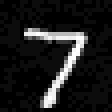

In [7]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order = Inf,
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

### $L_\infty$-norm Bounded Perturbations

We can bound the $L_\infty$-norm of the perturbation.

As long as the size of the $L_\infty$-norm bound we choose is larger than the actual ($L_\infty$-)minimal perturbation, we will find the same result, and often more quickly.

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
546.924763 seconds (1.90 M allocations: 72.457 MiB)


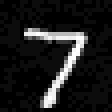

In [8]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=Inf,
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
 21.179666 seconds (2.99 M allocations: 102.860 MiB, 0.07% compilation time)


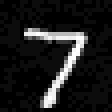

In [9]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05)
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

If the $L_\infty$-norm bound you choose is smaller than the actual minimal perturbation, the problem is infeasible. If you observe the following solve status, there is provably no perturbation within the selected $L_\infty$-norm bound (in this case `0.03`) that is an adversarial example.

In [10]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.03)
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
  0.336244 seconds (2.75 M allocations: 91.080 MiB, 20.55% gc time)


Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 0.0551291
  :TotalTime          => 0.336011
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[785] _[786] … _[811] _[812];;; _[813] _[814] … _[83…
  :TighteningApproach => "lp"
  :PerturbationFamily => linf-norm-bounded-0.03
  :SolveStatus        => INFEASIBLE
  :Model              => A JuMP Model…
  :Output             => AffExpr[0.0014746447222673583 _[785] + 0.0086289714433…
  :PredictedIndex     => 8

In [11]:
d[:SolveStatus]

INFEASIBLE::TerminationStatusCode = 2

### Blurring Perturbations

We can restrict the perturbations to a blur; in this case, we select a 5x5 kernel. (Note that we are still minimizing over the norm of the perturbation.)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
164.483624 seconds (4.45 M allocations: 210.833 MiB, 0.56% compilation time)


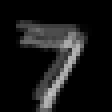

In [12]:
d = @time MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=Inf,
    pp = MIPVerify.BlurringPerturbationFamily((5, 5))
)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

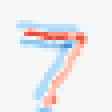

In [13]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

## Minimizing Over Different Norms
### $L_1$
By default, we minimize the $L_1$ norm of the perturbation. This generally encourages sparsity in the perturbations. 

In this case, the minimum $L_1$ norm perturbation required for the image to be classified as a `9` is `4.641859.`

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 4.641859, Solve Time: 364.94


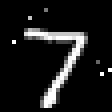

In [14]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=1
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

We also show the difference between the perturbed image and the original image. Red is areas of decreased brightness and blue is areas of increased brightness.

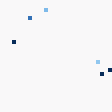

In [15]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $L_\infty$

We can also minimize over the $L_\infty$ norm. This generally results in large patches of the image being changed. 

In this case, the minimum $L_\infty$ norm perturbation required for the image to be classified as a `9` is `0.046085.`

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Objective Value: 0.046085, Solve Time: 545.87


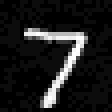

In [16]:
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=Inf
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])

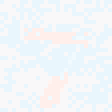

In [17]:
diff = value.(d[:Perturbation])
view_diff(diff[1, :, :, 1])

### $L_2$
HiGHS is unable to solve MIQPs. With a solver that can (like Gurobi) we can minimize over the $L_2$ norm. This generally takes a bit more time. 

In this case, the minimum $L_2$ norm perturbation required for the image to be classified as a `9` is `0.705367 = sqrt(0.497542).`

```julia
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => false),
    tightening_algorithm = lp,
    norm_order=2
)
print_summary(d)
perturbed_sample_image = value.(d[:PerturbedInput])
colorview(Gray, perturbed_sample_image[1, :, :, 1])
```

# Advanced Options

### `tightening_algorithm`

By default, we tighten the bounds on each intermediate value by solving an MIP using the `optimize` with the `tightening_options` specified. Compare total solve times for three different tightening algorithms. As the tightening algorithm gets more complex (`interval_arithmetic -> lp -> mip`), the time spent on tightening bounds increases, but generally (not in this case with `mip`) with a reduction in the amount of time for the main solve. 

You'll have to find the sweet spot for your own application.

In [20]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => true),
    tightening_algorithm = interval_arithmetic,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 846.962
  :TotalTime          => 847.007
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "interval_arithmetic"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

In [21]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => true),
    tightening_algorithm = lp,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 546.327
  :TotalTime          => 546.724
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

In [22]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("output_flag" => true),
    tightening_algorithm = mip,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 386.127
  :TotalTime          => 1062.21
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "mip"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

We can also modify many of the parameters of the solver to change behavior:

We will be focusing on the parameters available via [Gurobi](http://www.gurobi.com/documentation/11.0/refman/parameters.html) and [HiGHS](https://ergo-code.github.io/HiGHS/stable/options/definitions/), but other solvers often have similar options.

  
### `main_solve_options`

#### Muting Output
To mute the output from the `Gurobi`, set `OutputFlag=0`; for `HiGHS`, set `output_flag=false`.


#### Terminating early if a conditon is satisfied

Sometimes, finding an adversarial example takes a long time:

You may want to terminate early when a particular condition is satisfied. Common reasons are:

  1. Solve exceeding time limit
  2. Lower bound on robustness proved (i.e. `BestBd` increases above a pre-determined threshold)
  3. Counter-example found (i.e. `Incumbent` adversarial image found that is closer to the original image than expected).
  4. Difference between `Incumbent` and `BestBd` falls below a pre-determined threshold.
  
Fortunately, Gurobi has a parameter for all of these cases.

##### Terminate if time limit is reached
Set `TimeLimit` for `Gurobi`, and `time_limit` for `HiGHS`.

In [27]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("time_limit" => 10.0),
    tightening_algorithm = lp,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 10.0061
  :TotalTime          => 10.3976
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => TIME_LIMIT
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

##### Terminate if lower bound on robustness proved

Set `BestBdStop` for `Gurobi`, and `objective_bound` for `HiGHS`.

In [24]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("objective_bound" => 0.02),
    tightening_algorithm = lp,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               0.02*                inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               0.02*                inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 19.6953
  :TotalTime          => 20.1219
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => INFEASIBLE
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

##### Terminate if adversarial example found closer than expected robustness

Set `BestObjStop` for `Gurobi`, and `objective_target` for `HiGHS`.

In [25]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("objective_target" => 0.2),
    tightening_algorithm = lp,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 547.737
  :TotalTime          => 548.117
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

##### Terminate if gap between the incumbent and the best bound is below threshold

Set `MIPGap` for `Gurobi`, and `mip_abs_gap` for `HiGHS`.

In [26]:
@time d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10,
    HiGHS.Optimizer,
    Dict("mip_abs_gap" => 0.4),
    tightening_algorithm = lp,
    norm_order=Inf
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.
Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
1203 rows, 1020 cols, 66828 nonzeros
1203 rows, 1020 cols, 66828 nonzeros

Solving MIP model with:
   1203 rows
   1020 cols (60 binary, 0 integer, 0 implied int., 960 continuous)
   66828 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0  

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 1.23475
  :TotalTime          => 1.61724
  :Perturbation       => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :PerturbedInput     => [_[1] _[2] … _[27] _[28];;; _[29] _[30] … _[55] _[56];…
  :TighteningApproach => "lp"
  :PerturbationFamily => unrestricted
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => AffExpr[-0.012063867412507534 _[865] + 0.6606525778770…
  :PredictedIndex     => 8

Whew! That was a lot. The next tutorial will introduce you to everything you can extract from the results dictionary.